# Tradeoff between A long Time in range and Position width

The goal is to show that a wide position increases tha chance of keeping the price inside our position, thus maximizing the time of fee accumulation, while a narrow position concentrates our liquidity making our position genrate better returns.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def simulate_gbm(S0, mu, sigma, T, day_count, N):

    """
    Simulate geometric Brownian motion paths.

    Parameters:
    S0 (float): Initial stock price
    mu (float): Drift coefficient
    sigma (float): Diffusion coefficient
    T (float): Total time
    dt (float): Time step
    N (int): Number of paths

    Returns:
    np.ndarray: Simulated paths of shape (N, int(T/dt))
    """
    days = int(T * day_count)
    paths = np.zeros((N, days+1))
    paths[:, 0] = S0
    dt = 1/day_count
    for i in range(1, days+1):
        Z = np.random.standard_normal(N)
        paths[:, i] = paths[:, i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    return paths


def calculate_time_in_range(paths, lower_bound, upper_bound, day_count, T):

    """
    Calculate the expected time the asset price spends within the specified range.

    Parameters:
    paths (np.ndarray): Simulated GBM paths
    lower_bound (float): Lower bound of the range
    upper_bound (float): Upper bound of the range
    dt (float): Time step

    

    Returns:
    float: Expected time in the specified range

    """

    N, steps = paths.shape
    time_in_range = (np.sum((paths >= lower_bound) & (paths <= upper_bound), axis=1)) /day_count 
    expected_time_in_range = np.mean(time_in_range/T)

    return min(expected_time_in_range,1)

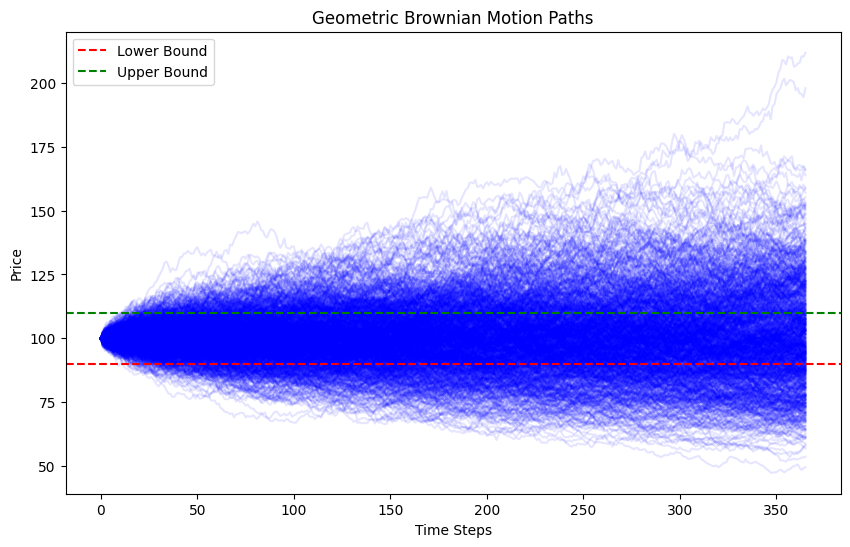

Expected time in range [90, 110], relative to position lifetime: 0.59


In [5]:
# Parameters

S0 = 100  # initial stock price
mu = 0  # drift coefficient
sigma = 0.2  # diffusion coefficient
T = 1 # total time (1 year)
day_count = 365  # time step (daily)
N = 1000  # number of paths

# Simulate GBM
paths = simulate_gbm(S0, mu, sigma, T, day_count, N)

# Define range
lower_bound = 90
upper_bound = 110

# Calculate expected time in range
expected_time_in_range = calculate_time_in_range(paths, lower_bound, upper_bound, day_count, T)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(paths.T, color='blue', alpha=0.1)
plt.axhline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axhline(upper_bound, color='green', linestyle='--', label='Upper Bound')
plt.title('Geometric Brownian Motion Paths')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

print(f"Expected time in range [{lower_bound}, {upper_bound}], relative to position lifetime: {expected_time_in_range:.2f}")

In [126]:
def rel_timeITM_plot(S0, mu, sigma, alphas, life_max, day_count, N):

    vals = dict()
    days = int(life_max * day_count)
    times = np.arange(1,days+1)/day_count

    for alpha in alphas:
        L = []
        for T in times:
            # Simulate GBM
            paths = simulate_gbm(S0, mu, sigma, T, day_count, N)

            # Define range
            lower_bound = S0/alpha
            upper_bound = S0*alpha

            # Calculate expected time in range
            expected_time_in_range = calculate_time_in_range(paths, lower_bound, upper_bound, day_count, T)
            L.append(expected_time_in_range)
        vals[alpha] = L
    
    plt.figure(figsize=(20,10))
    alphas.sort(reverse=True)
    for alpha in alphas:
        plt.scatter(times,vals[alpha], label=alpha)
    plt.xlabel("Position lifetime (T)")
    plt.ylabel("rel. Time ITM")
    plt.title("Impact of position width (Alpha) on the rel. Time ITM")
    plt.legend(title="Alpha Values")
    plt.show()

## A wider position increases the rel time where the price stays inside our position

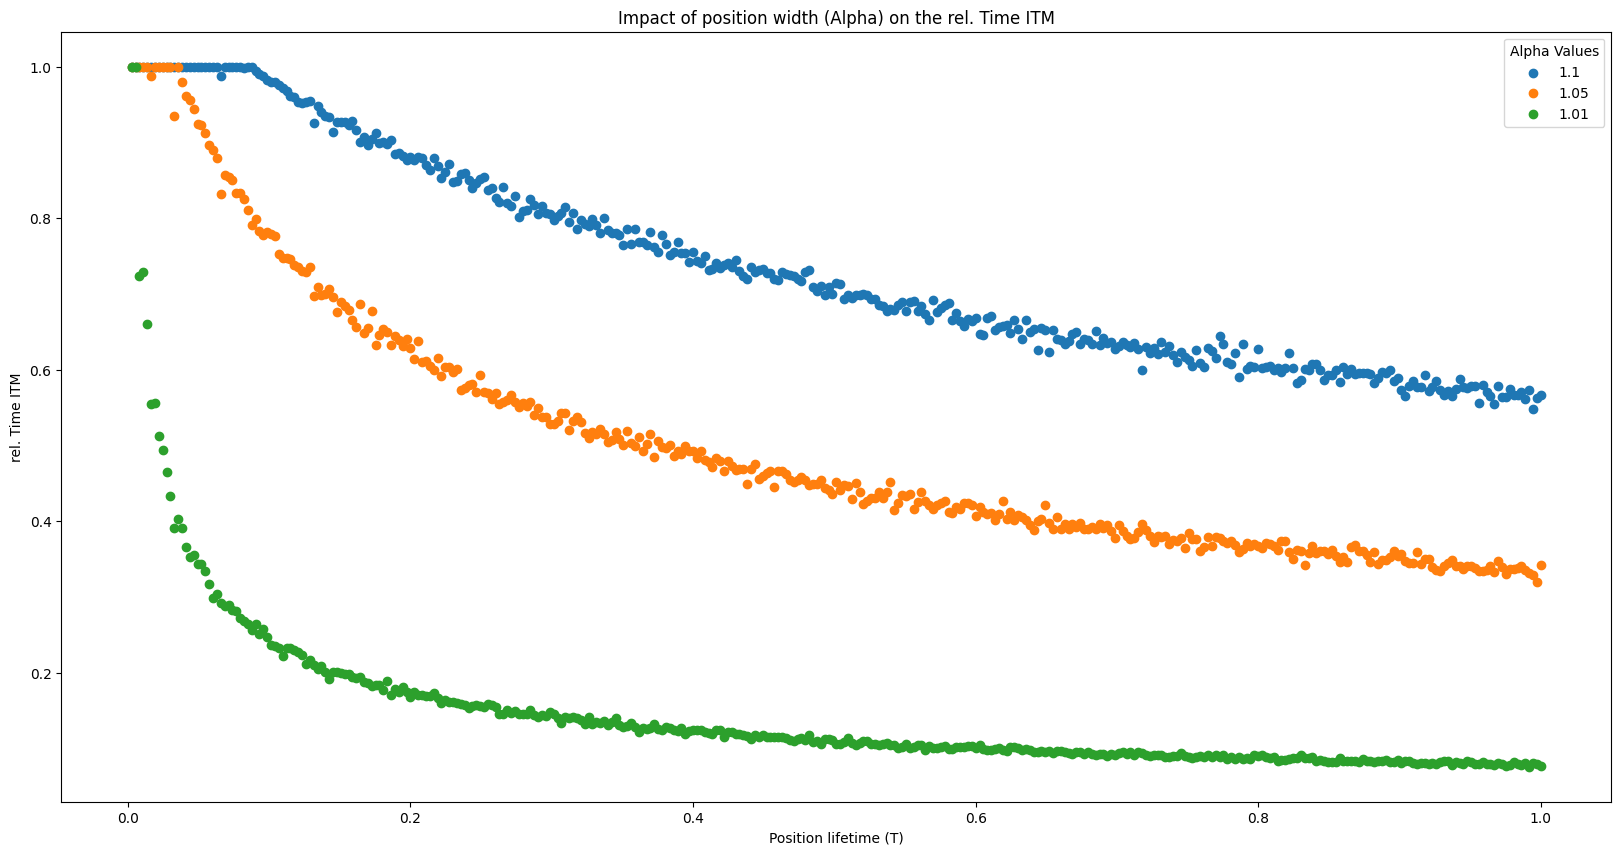

In [127]:
alphas = [1.01,1.05,1.1]
life_max = 1
rel_timeITM_plot(S0, mu, sigma, alphas, life_max, day_count, N)

In [124]:
def fees_model_plot(S0, mu, sigma, alpha_max, lifes, day_count, N):
    # F ~ Titm / alpha

    alphas = np.arange(1.01,alpha_max,0.01)
    vals = dict()
    days = int(life_max * day_count)

    for life in lifes:
        L = []
        for alpha in alphas:
            # Simulate GBM
            paths = simulate_gbm(S0, mu, sigma, life, day_count, N)

            # Define range
            lower_bound = S0/alpha
            upper_bound = S0*alpha

            # Calculate expected time in range
            expected_time_in_range = calculate_time_in_range(paths, lower_bound, upper_bound, day_count, life)
            L.append(expected_time_in_range/alpha)
        vals[life] = L
    
    plt.figure(figsize=(20,10))
    for life in lifes:
        plt.plot(alphas,vals[life], label=f"{life} years")
    plt.xlabel("Alpha values")
    plt.ylabel("rel. Time ITM rel. to Alpha")
    plt.title("Impact of position width (Alpha) on the recived fees according to ~T_itm/Alpha model")
    plt.legend(title="T values")
    plt.show()

### Taking fees into account, we can see that an optimal width is to be found to ensure a tradeoff between insresing our capital efficiency and limiting the risk of seeing the price leaving our position

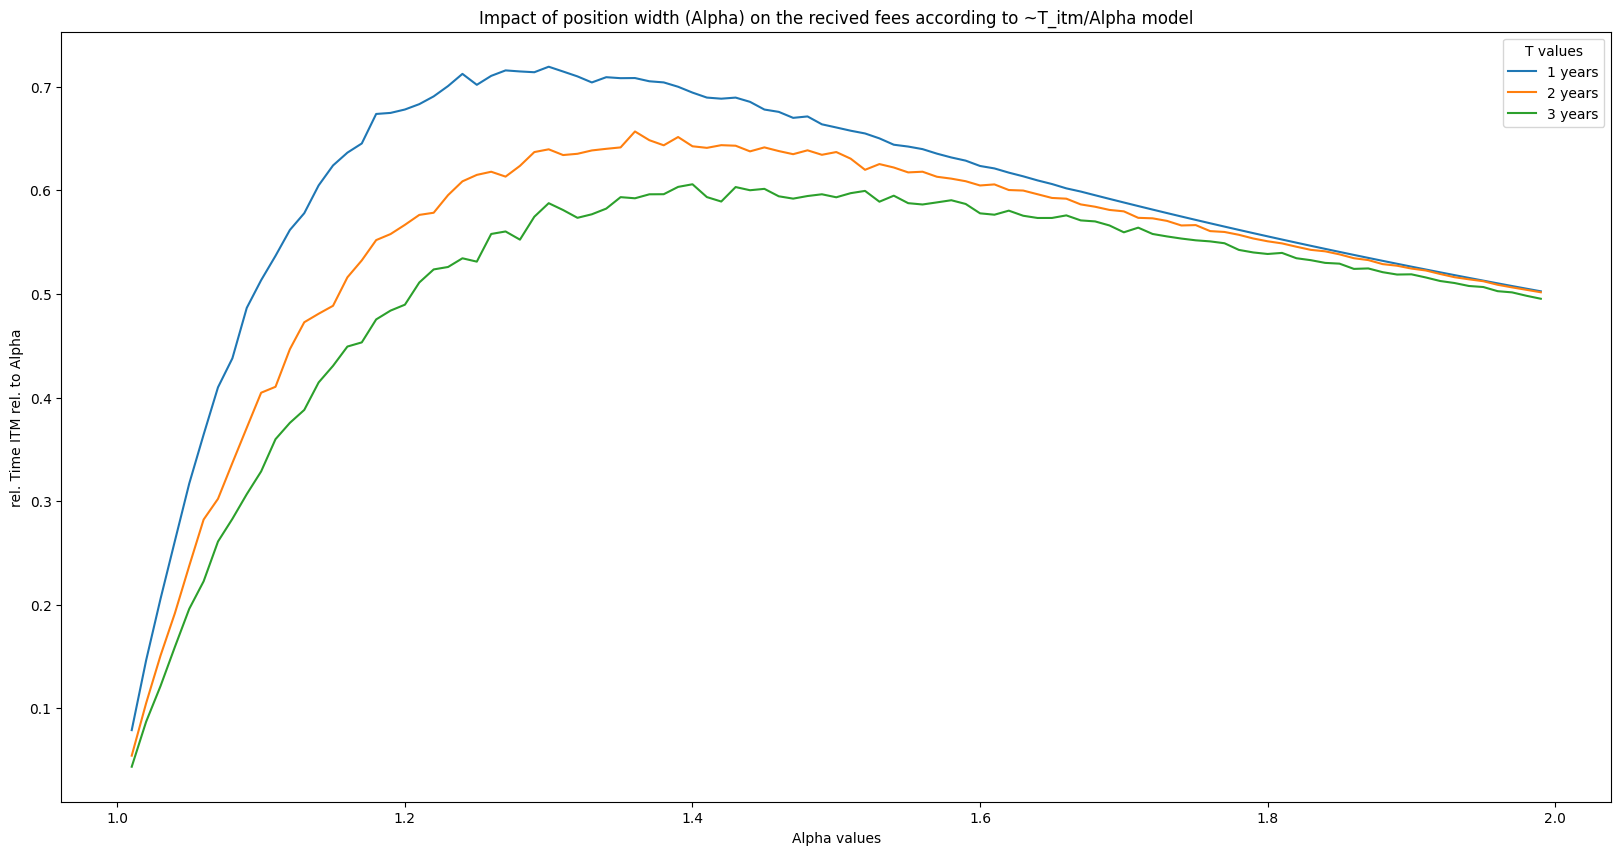

In [125]:
alpha_max = 2
lifes = [1, 2, 3]
fees_model_plot(S0, mu, sigma, alpha_max, lifes, day_count, N)